[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://github.com/CodingPro777/AAI-530-GROUP-1/edit/main/final_project_code.ipynb
)


# USD AAI-530 Group 1 final project - Machine Learning with IoT(FitBit Fitness)

*Group 1 members: Ali Abdul-Hameed, Jack Kim, Jinyuan He*

The dataset is from Kaggle and originates from Fitbit wearable devices. The dataset contains Fitbit sensor data collected from April 12, 2016 to May 12, 2016.

Data download link: [download](https://www.kaggle.com/datasets/arashnic/fitbit)



In [1]:
# load packages
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


# 1. Data cleaning & EDA

## 1.1 Loading dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# upload dataset zip file to google drive if not exist
google_drive_path = '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1'

zip_file_path = google_drive_path + '/archive.zip'

if not os.path.isfile(zip_file_path):
  from google.colab import files
  uploaded = files.upload()
  !mv archive.zip '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1'


!unzip '/content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1/archive.zip'

Archive:  /content/drive/MyDrive/USD/2026 Spring/AAI-530-GROUP-1/archive.zip
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyCalories_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlyIntensities_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/hourlySteps_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteIntensitiesNarrow_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteMETsNarrow_merged.csv  
  inflating: mturkfitbit_export_3.12.16-4.11.16/Fitabase

In [4]:
# combine two months dataset into one

raw_daily_activity_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/dailyActivity_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')]
)

raw_weight_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/weightLogInfo_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv')]
)

raw_hr_sec_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/heartrate_seconds_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv')]
)

raw_calories_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteCaloriesNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteCaloriesNarrow_merged.csv')]
)

raw_intensities_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteIntensitiesNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteIntensitiesNarrow_merged.csv')]
)

raw_mets_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteMETsNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteMETsNarrow_merged.csv')]
)

raw_sleep_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteSleep_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteSleep_merged.csv')]
)


raw_step_min_df = pd.concat(
    [pd.read_csv('/content/mturkfitbit_export_3.12.16-4.11.16/Fitabase Data 3.12.16-4.11.16/minuteStepsNarrow_merged.csv'),
    pd.read_csv('/content/mturkfitbit_export_4.12.16-5.12.16/Fitabase Data 4.12.16-5.12.16/minuteStepsNarrow_merged.csv')]
)

## 1.2 Dataset for calories prediction

In [5]:
# merge data files of intentity, METs and step
calories_df = raw_calories_min_df.merge(
    raw_intensities_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_mets_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df = calories_df.merge(
    raw_step_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

calories_df['ActivityMinute'] = pd.to_datetime(
    calories_df['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p'
)


In [6]:
calories_df.isna().sum()

,0
Id,0
ActivityMinute,0
Calories,0
Intensity,0
METs,0
Steps,0


In [7]:
number_cols = [
    'Calories',
    'Intensity',
    'METs',
    'Steps'
]

calories_df[number_cols] = calories_df[number_cols].apply(pd.to_numeric)

In [8]:
pd.options.display.float_format = '{:.0f}'.format
calories_df.describe()

,Id,ActivityMinute,Calories,Intensity,METs,Steps
count,2917620,2917620,2917620,2917620,2917620,2917620
mean,4866573178,2016-04-10 19:20:27.486581760,2,0,14,5
min,1503960366,2016-03-12 00:00:00,0,0,0,0
25%,2320127002,2016-03-27 08:23:00,1,0,10,0
50%,4558609924,2016-04-12 01:12:00,1,0,10,0
75%,6962181067,2016-04-24 19:45:00,1,0,11,0
max,8877689391,2016-05-12 15:59:00,23,3,189,220
std,2433466479,NaN,1,1,12,18


### 1.2.1 Check minute-level time continuity in the dataset

In [9]:
# Sort by value
calories_df = calories_df.sort_values(['Id', 'ActivityMinute'], ascending=True)

# Remove duplicated data
calories_df = calories_df.drop_duplicates(subset=['Id', 'ActivityMinute'])

# Check minute-level time continuity in the dataset
calories_df.groupby('Id')['ActivityMinute'].diff().value_counts().head(30)

,count
ActivityMinute,
0 days 00:01:00,2760074
0 days 04:01:00,2
1 days 20:01:00,1
1 days 09:01:00,1
3 days 01:01:00,1
0 days 02:01:00,1
0 days 14:01:00,1
2 days 01:01:00,1
9 days 07:01:00,1


#### PS: The minute-level activity data is largely continuous, with over 99% of consecutive records occurring at 1-minute intervals. A small number of duplicate timestamps and occasional multi-hour gaps were observed, likely due to device synchronization or user inactivity.

In [10]:
# We mark time gaps in the data so that the records can be separated into sessions or removed when training time-series models.
calories_df['minute_gap'] = (
    calories_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
      .div(60)
)

calories_df['has_gap'] = (calories_df['minute_gap'] > 1).astype(int)

In [11]:
# Split into contiguous segments (per user)
calories_df['time_diff'] = (
    calories_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
)

EXPECTED_INTERVAL = 60   # second
THRESHOLD = 60 * 2  # 2 mins

calories_df['new_segment'] = (
    (calories_df['time_diff'] > THRESHOLD) |
    calories_df['time_diff'].isna()
)

calories_df['segment_id'] = (
    calories_df.groupby('Id')['new_segment']
      .cumsum()
)

calories_df['segment_uid'] = (
    calories_df['Id'].astype(str) + '_' +
    calories_df['segment_id'].astype(str)
)

# Filter long segments
segment_stats = (
    calories_df.groupby(['Id', 'segment_uid'])
      .agg(
          start_time=('ActivityMinute', 'min'),
          end_time=('ActivityMinute', 'max'),
          n_points=('ActivityMinute', 'count')
      )
      .reset_index()
)

segment_stats['duration_sec'] = (
    segment_stats['end_time'] - segment_stats['start_time']
).dt.total_seconds()

valid_segments = segment_stats[
    segment_stats['duration_sec'] >= THRESHOLD
]

calories_merged_df = calories_df.merge(
    valid_segments[['segment_uid']],
    on='segment_uid',
    how='inner'
)

### 1.2.2 EDA

In [12]:
print(f"""
Number of users: {calories_merged_df['Id'].nunique()}
Number of segments: {calories_merged_df['segment_uid'].nunique()}
Number of points: {calories_merged_df['ActivityMinute'].count()}

Longest segment: {calories_merged_df['segment_uid'].value_counts().max() / 60} hours
Shortest segment: {calories_merged_df['segment_uid'].value_counts().min() / 60} hours
Average segment: {calories_merged_df['segment_uid'].value_counts().mean() / 60} hours
""")


Number of users: 35
Number of segments: 46
Number of points: 2760120

Longest segment: 1480.0 hours
Shortest segment: 12.0 hours
Average segment: 1000.0434782608696 hours



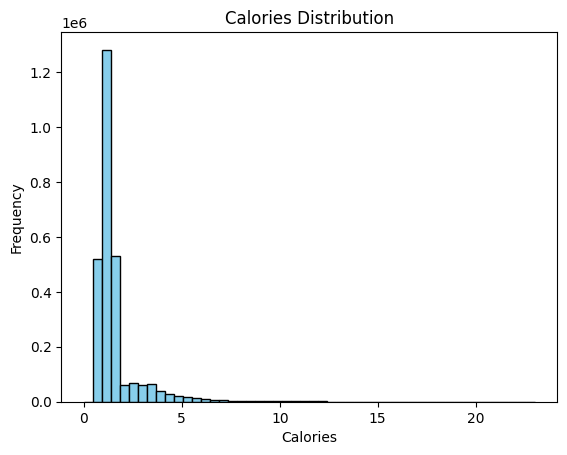

In [13]:

plt.hist(calories_merged_df['Calories'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.title('Calories Distribution')
plt.show()

array([[<Axes: title={'center': 'Steps'}>,
        <Axes: title={'center': 'METs'}>],
       [<Axes: title={'center': 'Intensity'}>, <Axes: >]], dtype=object)

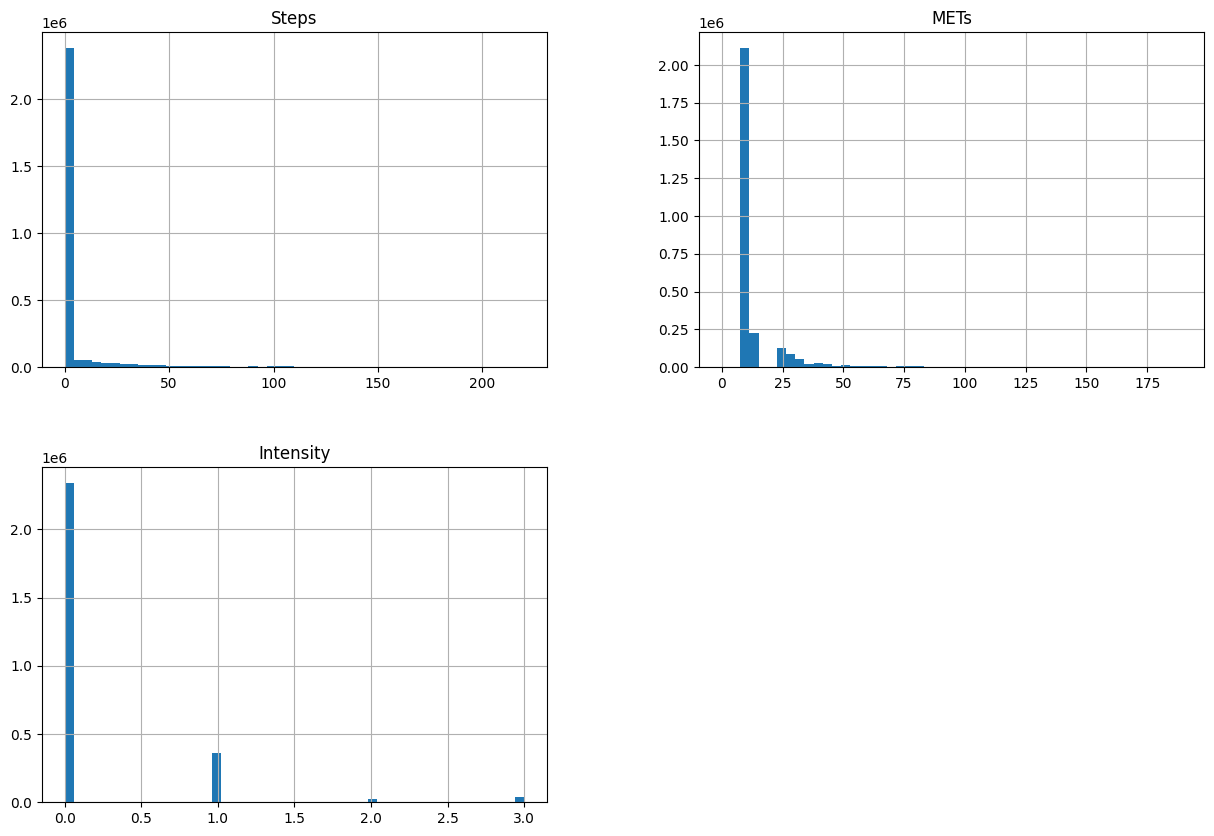

In [14]:
calories_merged_df[['Steps', 'METs', 'Intensity']].hist(bins=50, figsize=(15,10))

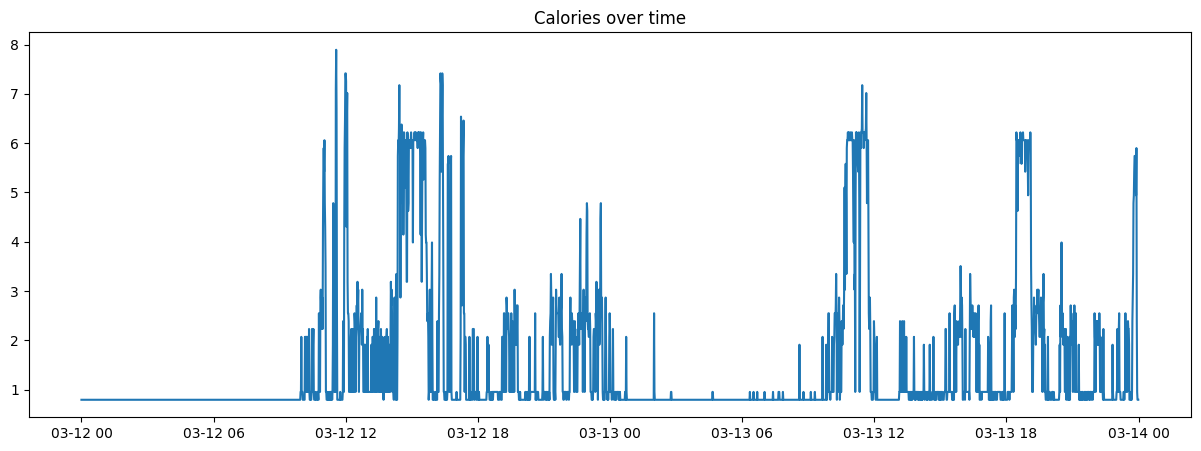

In [15]:
uid = calories_merged_df['Id'].iloc[0]

sample = (
    calories_merged_df[calories_merged_df['Id'] == uid]
        .head(2 * 24 * 60)
)
plt.figure(figsize=(15, 5))
plt.plot(sample['ActivityMinute'], sample['Calories'], label='Calories')
plt.title('Calories over time')
plt.show()

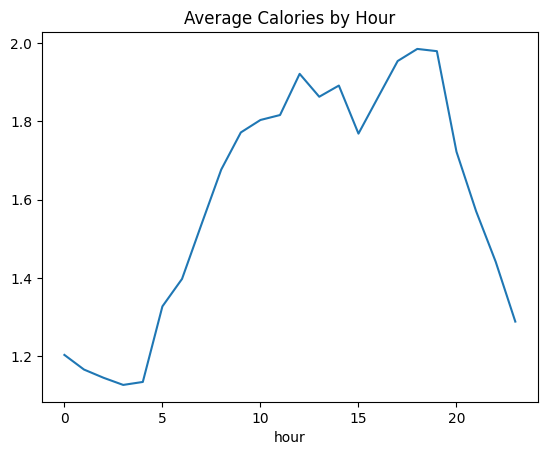

In [16]:
calories_merged_df['hour'] = calories_merged_df['ActivityMinute'].dt.hour

calories_merged_df.groupby('hour')['Calories'].mean().plot(kind='line')
plt.title('Average Calories by Hour')
plt.show()

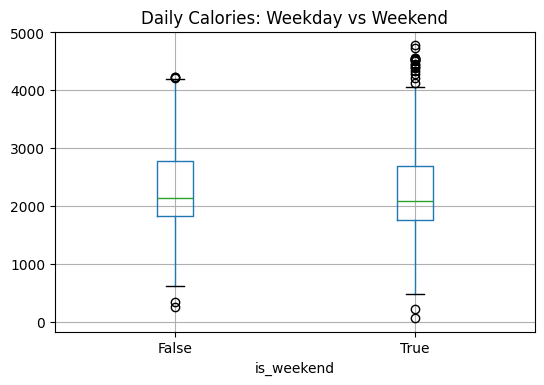

In [17]:
df = calories_merged_df.copy()

df["dayofweek"] = df["ActivityMinute"].dt.dayofweek
# Monday=0, Sunday=6
df["is_weekend"] = df["dayofweek"].isin([5, 6])

daily = (
    df.groupby(["Id", "is_weekend", df["ActivityMinute"].dt.date])["Calories"]
      .sum()
      .reset_index()
)

daily.boxplot(column="Calories", by="is_weekend", figsize=(6,4))
plt.title("Daily Calories: Weekday vs Weekend")
plt.suptitle("")
plt.show()

In [18]:
calories_merged_df[calories_merged_df['segment_id'] > 1]

,Id,ActivityMinute,Calories,Intensity,METs,Steps,minute_gap,has_gap,time_diff,new_segment,segment_id,segment_uid,hour
218460,1644430081,2016-04-12 00:00:00,1,0,10,0,2641,1,158460,True,2,1644430081_2,0
218461,1644430081,2016-04-12 00:01:00,1,0,10,0,1,0,60,False,2,1644430081_2,0
218462,1644430081,2016-04-12 00:02:00,1,0,10,0,1,0,60,False,2,1644430081_2,0
218463,1644430081,2016-04-12 00:03:00,1,0,10,0,1,0,60,False,2,1644430081_2,0
218464,1644430081,2016-04-12 00:04:00,1,0,10,0,1,0,60,False,2,1644430081_2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586475,8583815059,2016-05-11 21:55:00,1,0,10,0,1,0,60,False,2,8583815059_2,21
2586476,8583815059,2016-05-11 21:56:00,1,0,10,0,1,0,60,False,2,8583815059_2,21
2586477,8583815059,2016-05-11 21:57:00,1,0,10,0,1,0,60,False,2,8583815059_2,21
2586478,8583815059,2016-05-11 21:58:00,2,0,11,0,1,0,60,False,2,8583815059_2,21


#### Interpretation

**1. Calories Distribution**
From the calories distribution, we observe that most calories burned per minute fall within the range of approximately 0 to 1.5, forming a right-skewed distribution. This indicates that while most minutes involve low energy expenditure, users occasionally reach much higher calorie burn levels, likely during periods of exercise. Similarly, Steps, METs, and Intensity exhibit comparable right-skewed patterns, reflecting sporadic bursts of higher activity.

**2. Hourly Activity Pattern**
The hourly average plot shows that calorie expenditure is lowest during nighttime hours and higher during daytime, corresponding to typical human activity and rest cycles. This pattern is consistent with expected daily routines and supports the validity of the data.

**3. Weekday vs. Weekend Comparison**
The boxplot comparison shows that daily calories burned on weekends are slightly higher than on weekdays. The medians and interquartile ranges are comparable for both groups, and no obvious abnormal patterns are observed, indicating a generally consistent distribution of calorie expenditure across weekdays and weekends.



### 1.2.3 Features Correlation

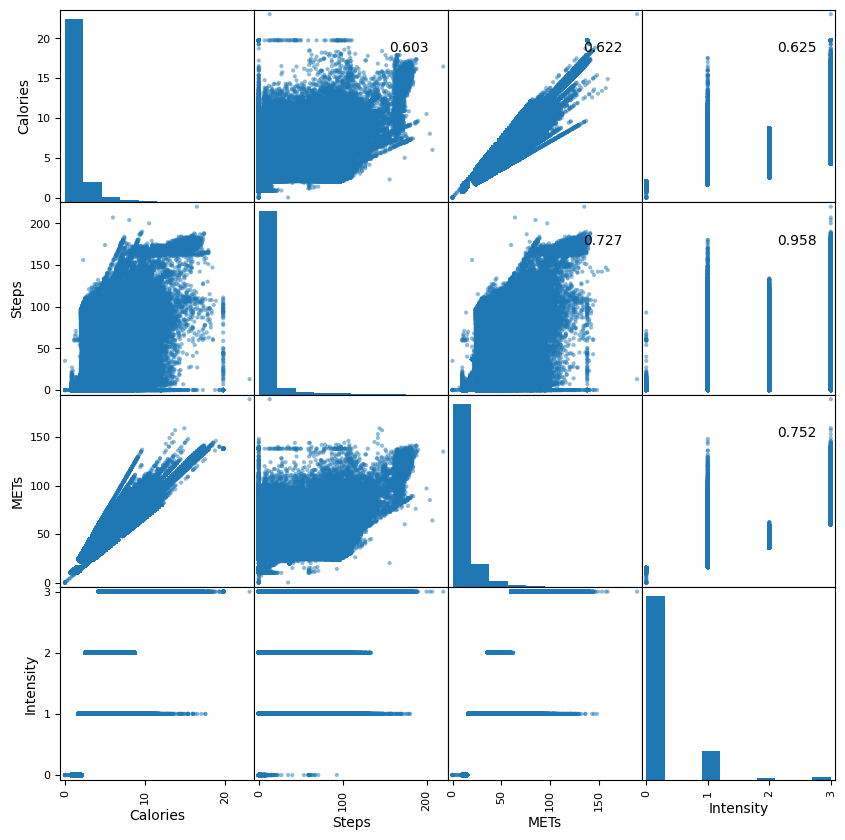

In [19]:
axes = pd.plotting.scatter_matrix(calories_merged_df[['Calories','Steps','METs','Intensity']], alpha=0.5,figsize= [10,10])
corr = calories_merged_df[['Calories','Steps','METs','Intensity']].corr(method = 'spearman').to_numpy()
#nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
  axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

## 1.3 Dataset for sleep status prediction



*   Merge sleep status with heart rate(min, max, avg)/Intensity/METs
*   Split into contiguous segments (per user)
*   Filter long segments




In [20]:
# ensure datetime
raw_hr_sec_df['Time'] = pd.to_datetime(raw_hr_sec_df['Time'])

# drill up to minute
raw_hr_sec_df['ActivityMinute'] = raw_hr_sec_df['Time'].dt.floor('min')

# aggregate
hr_min_df = (
    raw_hr_sec_df.groupby(['Id', 'ActivityMinute'])['Value']
      .agg(
          min_hr='min',
          max_hr='max',
          avg_hr='mean'
      )
      .reset_index()
)

In [93]:
# Merge sleep status with heart rate(min, max, avg)/Intensity/METs
raw_intensities_min_df['ActivityMinute'] = pd.to_datetime(
    raw_intensities_min_df['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p'
)

raw_mets_min_df['ActivityMinute'] = pd.to_datetime(
    raw_mets_min_df['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p'
)

raw_step_min_df['ActivityMinute'] = pd.to_datetime(
    raw_step_min_df['ActivityMinute'],
    format='%m/%d/%Y %I:%M:%S %p'
)

raw_sleep_min_df['date'] = pd.to_datetime(
    raw_sleep_min_df['date'],
    format='%m/%d/%Y %I:%M:%S %p'
)

raw_sleep_min_df['ActivityMinute'] = raw_sleep_min_df['date'].dt.floor('T')

sleep_status_df = raw_sleep_min_df.merge(
    hr_min_df,
    on=['Id', 'ActivityMinute'],
    # left_on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_intensities_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_mets_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)

sleep_status_df = sleep_status_df.merge(
    raw_step_min_df,
    on=['Id', 'ActivityMinute'],
    how='left'
)


/tmp/ipython-input-888302272.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  raw_sleep_min_df['ActivityMinute'] = raw_sleep_min_df['date'].dt.floor('T')


In [94]:
# Drop the 'date' and 'logId' columns as they are not needed after merging and before interpolation.
sleep_status_df.drop(columns=['date', 'logId'], inplace=True)

# drop duplicate
sleep_status_df = sleep_status_df.drop_duplicates(subset=['Id', 'ActivityMinute'])

print("NaNs before interpolation (after dropping 'date' and 'logId'):")
print(sleep_status_df.isna().sum())

NaNs before interpolation (after dropping 'date' and 'logId'):
Id                     0
value                  0
ActivityMinute         0
min_hr            273216
max_hr            273216
avg_hr            273216
Intensity           1068
METs                1068
Steps               1068
dtype: int64


In [118]:
# Columns to interpolate: Intensity, METs, Steps, and value (sleep status)
cols_to_interpolate = ['Intensity', 'METs', 'Steps']

sleep_status_df.dropna(subset=['ActivityMinute'], inplace=True)

# Ensure 'ActivityMinute' is a datetime object and sort the DataFrame
sleep_status_df['ActivityMinute'] = pd.to_datetime(sleep_status_df['ActivityMinute'])
sleep_status_df.sort_values(by=['Id', 'ActivityMinute'], inplace=True)


# Temporarily set 'ActivityMinute' as the index for interpolation
sleep_status_df_indexed = sleep_status_df.set_index('ActivityMinute').copy()

for col in cols_to_interpolate:
    # Perform group-wise time-based interpolation
    sleep_status_df_indexed[col] = sleep_status_df_indexed.groupby('Id')[col].transform(
        lambda x: x.interpolate(method='time', limit=60, limit_direction='both')
    )

# Reset the index and update the original DataFrame
sleep_status_df = sleep_status_df_indexed.reset_index()

# #Drop any remaining NaNs in 'value' after interpolation (these would be large gaps)
# sleep_status_df.dropna(subset=['value'], inplace=True)
sleep_status_df.dropna(inplace=True)

print("\nNaNs after interpolating small gaps and dropping large value NaNs:")
print(sleep_status_df.isna().sum())


NaNs after interpolating small gaps and dropping large value NaNs:
ActivityMinute    0
Id                0
value             0
min_hr            0
max_hr            0
avg_hr            0
Intensity         0
METs              0
Steps             0
time_diff         0
new_segment       0
segment_id        0
segment_uid       0
dtype: int64


In [119]:
# Sort by value
sleep_status_df = sleep_status_df.sort_values(['Id', 'ActivityMinute'], ascending=True)

# Remove duplicated data
sleep_status_df = sleep_status_df.drop_duplicates(subset=['Id', 'ActivityMinute'])


# Check minute-level time continuity in the dataset
sleep_status_df.groupby('Id')['ActivityMinute'].diff().value_counts()

,count
ActivityMinute,
0 days 00:01:00,109043
0 days 00:02:00,41
0 days 00:03:00,36
0 days 00:04:00,18
0 days 00:05:00,17
...,...
3 days 16:57:00,1
0 days 17:25:00,1
0 days 16:41:00,1


In [120]:
sleep_status_df['time_diff'] = (
    sleep_status_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
)

In [121]:
# Split into contiguous segments (per user)
sleep_status_df['time_diff'] = (
    sleep_status_df.groupby('Id')['ActivityMinute']
      .diff()
      .dt.total_seconds()
)

EXPECTED_INTERVAL = 60   # second
THRESHOLD = 60 * 60 * 2  # 2 hours

sleep_status_df['new_segment'] = (
    (sleep_status_df['time_diff'] > THRESHOLD) |
    sleep_status_df['time_diff'].isna()
)

sleep_status_df['segment_id'] = (
    sleep_status_df.groupby('Id')['new_segment']
      .cumsum()
)

sleep_status_df['segment_uid'] = (
    sleep_status_df['Id'].astype(str) + '_' +
    sleep_status_df['segment_id'].astype(str)
)

# Filter long segments
segment_stats = (
    sleep_status_df.groupby(['Id', 'segment_uid'])
      .agg(
          start_time=('ActivityMinute', 'min'),
          end_time=('ActivityMinute', 'max'),
          n_points=('ActivityMinute', 'count')
      )
      .reset_index()
)

segment_stats['duration_sec'] = (
    segment_stats['end_time'] - segment_stats['start_time']
).dt.total_seconds()

valid_segments = segment_stats[
    segment_stats['duration_sec'] >= THRESHOLD
]

sleep_status_merge_df = sleep_status_df.merge(
    valid_segments[['segment_uid']],
    on='segment_uid',
    how='inner'
)

In [122]:
sleep_status_merge_df.groupby('segment_uid')['ActivityMinute'].diff().value_counts().head()

,count
ActivityMinute,
0 days 00:01:00,107301
0 days 00:02:00,38
0 days 00:03:00,35
0 days 00:04:00,18
0 days 00:05:00,15


### 1.3.1 EDA

In [123]:
print(f"""
Number of users: {sleep_status_merge_df['Id'].nunique()}
Number of segments: {sleep_status_merge_df['segment_uid'].nunique()}
Number of points: {sleep_status_merge_df['ActivityMinute'].count()}

Longest segment: {sleep_status_merge_df['segment_uid'].value_counts().max() / 60} hours
Shortest segment: {sleep_status_merge_df['segment_uid'].value_counts().min() / 60} hours
Average segment: {sleep_status_merge_df['segment_uid'].value_counts().mean() / 60} hours
""")


Number of users: 11
Number of segments: 242
Number of points: 107785

Longest segment: 14.916666666666666 hours
Shortest segment: 1.5333333333333334 hours
Average segment: 7.423209366391185 hours



In [124]:
sleep_status_merge_df.describe()

,ActivityMinute,Id,value,min_hr,max_hr,avg_hr,Intensity,METs,Steps,time_diff,segment_id
count,107785,107785,107785,107785,107785,107785,107785,107785,107785,107774,107785
mean,2016-04-19 21:44:35.890337536,5644554659,1,60,63,62,0,10,0,261,18
min,2016-03-29 00:00:00,2026352035,1,37,40,39,0,10,0,60,1
25%,2016-04-09 05:18:00,4388161847,1,55,58,56,0,10,0,60,7
50%,2016-04-20 02:45:00,5577150313,1,60,63,61,0,10,0,60,16
75%,2016-04-30 01:41:00,6962181067,1,65,68,66,0,10,0,60,25
max,2016-05-12 08:00:00,8792009665,3,122,147,126,1,70,54,1539000,50
std,NaN,1712746786,0,8,9,8,0,2,1,8299,12


<Axes: xlabel='length', ylabel='Count'>

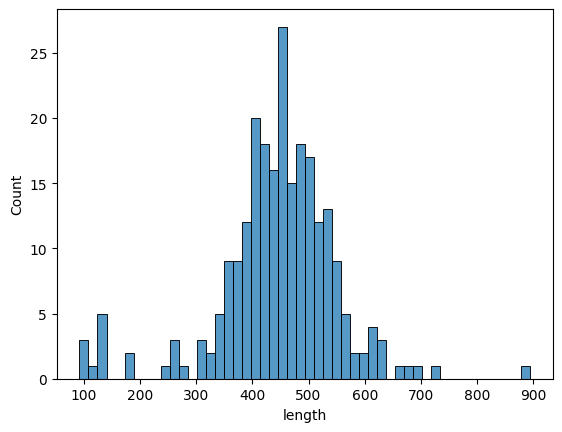

In [125]:
segment_stats = (
    sleep_status_merge_df.groupby(['Id','segment_uid'])
      .size()
      .reset_index(name='length')
)

sns.histplot(segment_stats['length'], bins=50)

In [126]:
sleep_status_merge_df['value'].value_counts().sort_index()


,count
value,
1,100969
2,5797
3,1019


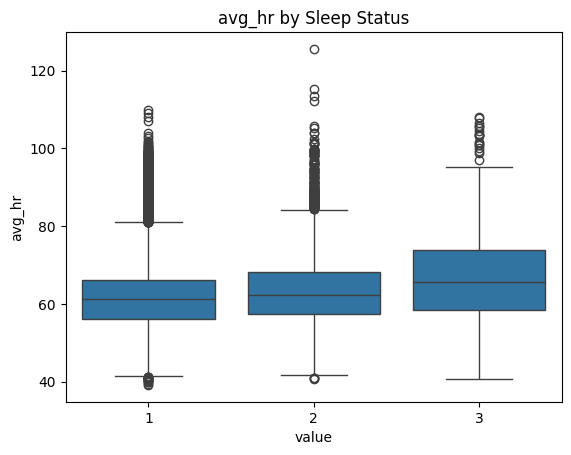

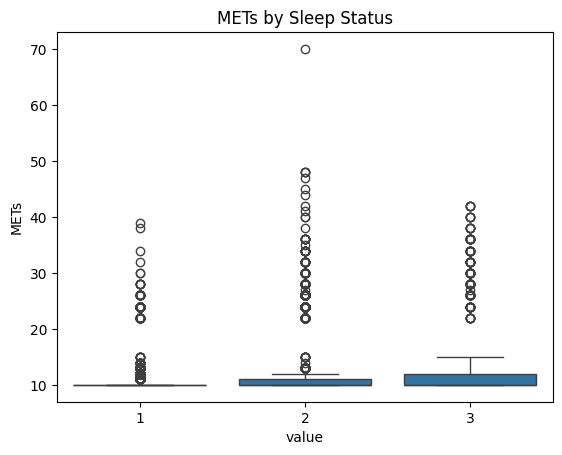

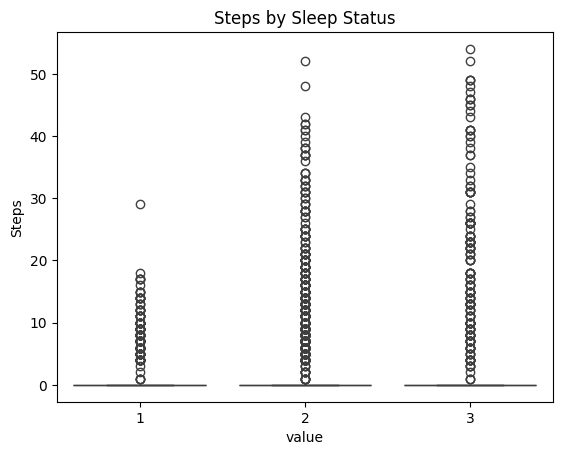

In [127]:
features = ['avg_hr', 'METs', 'Steps']

for f in features:
    sns.boxplot(
        x='value',
        y=f,
        data=sleep_status_merge_df
    )
    plt.title(f'{f} by Sleep Status')
    plt.show()

<Axes: xlabel='hour', ylabel='count'>

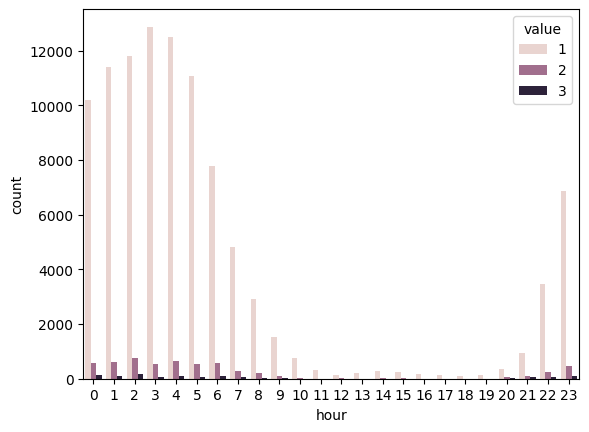

In [128]:
sleep_status_merge_df['hour'] = sleep_status_merge_df['ActivityMinute'].dt.hour

sns.countplot(
    x='hour',
    hue='value',
    data=sleep_status_merge_df
)

<Axes: xlabel='Id'>

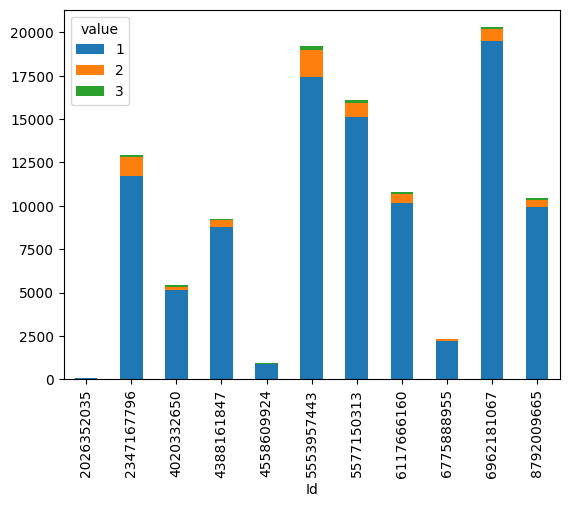

In [129]:
user_sleep_dist = (
    sleep_status_merge_df.groupby(['Id','value'])
           .size()
           .unstack(fill_value=0)
)

user_sleep_dist.plot(kind='bar', stacked=True)

#### Interpretation

In this dataset, sleep status is classified into three device-defined categories:
`1 = Asleep, 2 = Restless, and 3 = Awake`.

From the boxplots, the average heart rate during the `Asleep` state is consistently lower than in the other two states, which aligns with expected physiological patterns during sleep. In contrast, the `Awake` state exhibits significantly higher heart rates and greater variability, reflecting increased physical and mental activity. A similar trend is observed for METs, where activity intensity increases progressively from Asleep to `Awake`.

Notably, the `Restless` state shows a larger number of high-value outliers in both heart rate and `METs`. This suggests intermittent body movements, such as turning or repositioning during sleep, which are captured by wearable sensors as short bursts of activity. Correspondingly, step counts occasionally appear in both Restless and `Awake` states, likely caused by motion artifacts rather than sustained walking behavior.

Temporal distribution analysis indicates that most sleep records occur during nighttime hours, consistent with typical circadian sleep patterns. However, a non-negligible portion of sleep observations is also present during daytime, which may correspond to daytime naps or irregular sleep schedules.

Finally, user-level distributions reveal that most individuals exhibit a dominant `Asleep` state, with fewer observations in `Restless` and Awake states. This consistent pattern across users suggests stable sleep behavior and supports the generalizability of downstream sleep state modeling.





### 1.3.2 Features Correlation

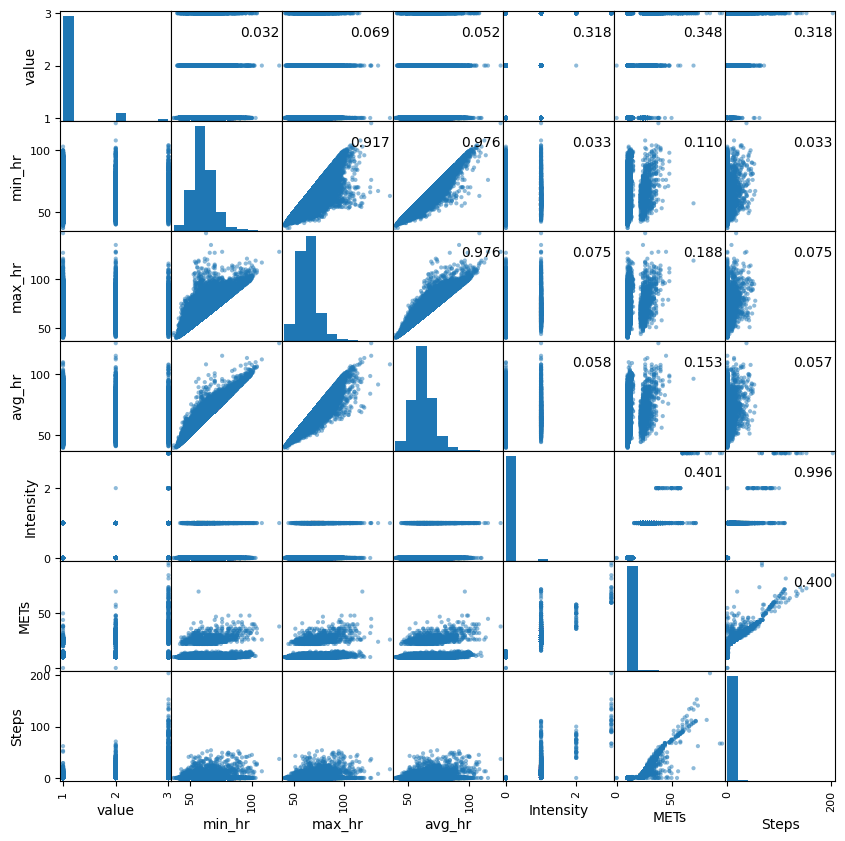

In [107]:
axes = pd.plotting.scatter_matrix(sleep_status_merge_df[['value','min_hr','max_hr','avg_hr','Intensity','METs','Steps']], alpha=0.5,figsize= [10,10])
corr = sleep_status_merge_df[['value','min_hr','max_hr','avg_hr','Intensity','METs','Steps']].corr(method = 'spearman').to_numpy()
#nonlinear
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
  axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

plt.show()

## 1.4 Save cleaned datasets

In [130]:
calories_merged_df[['Id', 'ActivityMinute', 'Calories', 'Intensity', 'METs', 'Steps']]. \
      to_csv(google_drive_path + '/calories_merged_df.csv')
sleep_status_merge_df[['Id', 'ActivityMinute', 'min_hr', 'max_hr', 'avg_hr', 'Intensity', 'METs', 'Steps', 'value', 'segment_uid']]. \
      to_csv(google_drive_path + '/sleep_status_merge_df.csv')

In [131]:
# load cleaned dataset

# calories_merged_df = pd.read_csv(google_drive_path + '/calories_merged_df.csv')
# sleep_status_merge_df = pd.read_csv(google_drive_path + '/sleep_status_merge_df.csv')
# sleep_status_merge_df

# 2. Model traning

# Task
Build and evaluate an LSTM model for sleep status prediction using the "sleep_status_merge_df.csv" dataset.

## Prepare data for LSTM


In [158]:
sleep_status_merge_df = pd.read_csv(google_drive_path + '/sleep_status_merge_df.csv', index_col=0)
sleep_status_merge_df['ActivityMinute'] = pd.to_datetime(sleep_status_merge_df['ActivityMinute'])
print(sleep_status_merge_df.head())
print(sleep_status_merge_df.info())

           Id      ActivityMinute  min_hr  max_hr  avg_hr  Intensity  METs  \
0  2026352035 2016-04-02 00:08:00      61      62      62          0    10   
1  2026352035 2016-04-02 00:09:00      62      63      63          0    10   
2  2026352035 2016-04-02 00:10:00      61      63      62          0    10   
3  2026352035 2016-04-02 00:11:00      61      63      61          0    10   
4  2026352035 2016-04-02 00:12:00      61      61      61          0    10   

   Steps  value   segment_uid  
0      0      1  2026352035_1  
1      0      1  2026352035_1  
2      0      1  2026352035_1  
3      0      1  2026352035_1  
4      0      1  2026352035_1  
<class 'pandas.core.frame.DataFrame'>
Index: 107785 entries, 0 to 107784
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Id              107785 non-null  int64         
 1   ActivityMinute  107785 non-null  datetime64[ns]
 2   min_hr          

In [170]:
sleep_status_merge_df['hour'] = sleep_status_merge_df['ActivityMinute'].dt.hour
sleep_status_merge_df['hour_sin'] = np.sin(2 * np.pi * sleep_status_merge_df['hour']/24)
sleep_status_merge_df['hour_cos'] = np.cos(2 * np.pi * sleep_status_merge_df['hour']/24)

print(sleep_status_merge_df[['ActivityMinute', 'hour', 'hour_sin', 'hour_cos']].head())

       ActivityMinute  hour  hour_sin  hour_cos
0 2016-04-02 00:08:00     0         0         1
1 2016-04-02 00:09:00     0         0         1
2 2016-04-02 00:10:00     0         0         1
3 2016-04-02 00:11:00     0         0         1
4 2016-04-02 00:12:00     0         0         1


**Reasoning**:
The next step is to add a 5-minute rolling mean for 'avg_hr' to the `sleep_status_merge_df` DataFrame, which will capture short-term trends in heart rate and provide more context to the LSTM model. This aligns with the main task of creating the `rolling_mean_avg_hr` feature.



In [171]:
sleep_status_merge_df['rolling_mean_5_hr'] = sleep_status_merge_df.groupby('Id')['avg_hr'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
sleep_status_merge_df['rolling_mean_15_hr'] = sleep_status_merge_df.groupby('Id')['avg_hr'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())

sleep_status_merge_df['rolling_mean_METs'] = sleep_status_merge_df.groupby('Id')['METs'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
sleep_status_merge_df['rolling_mean_Intensity'] = sleep_status_merge_df.groupby('Id')['Intensity'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

sleep_status_merge_df[['ActivityMinute', 'avg_hr', 'rolling_mean_5_hr', 'rolling_mean_15_hr', 'rolling_mean_METs', 'rolling_mean_Intensity']].head()

,ActivityMinute,avg_hr,rolling_mean_5_hr,rolling_mean_15_hr,rolling_mean_METs,rolling_mean_Intensity
0,2016-04-02 00:08:00,62,62,62,10,0
1,2016-04-02 00:09:00,63,62,62,10,0
2,2016-04-02 00:10:00,62,62,62,10,0
3,2016-04-02 00:11:00,61,62,62,10,0
4,2016-04-02 00:12:00,61,62,62,10,0


In [172]:
features = [
    'min_hr', 'max_hr', 'avg_hr', 'Intensity', 'METs', 'Steps',
    'hour_sin', 'hour_cos', 'rolling_mean_5_hr', 'rolling_mean_15_hr',
    'rolling_mean_METs', 'rolling_mean_Intensity'
]
target = 'value'

X = sleep_status_merge_df[features]
y = sleep_status_merge_df[target]

# One-hot encode the target variable again, just in case the previous state was lost or modified
y_encoded = to_categorical(y - 1, num_classes=3)

print("Updated features list:", features)
print("Shape of X with new features:", X.shape)
print("Shape of y_encoded:", y_encoded.shape)

Updated features list: ['min_hr', 'max_hr', 'avg_hr', 'Intensity', 'METs', 'Steps', 'hour_sin', 'hour_cos', 'rolling_mean_5_hr', 'rolling_mean_15_hr', 'rolling_mean_METs', 'rolling_mean_Intensity']
Shape of X with new features: (107785, 12)
Shape of y_encoded: (107785, 3)


In [173]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Shape of scaled features with new features:", X_scaled.shape)
print("First 5 rows of scaled features with new features:\n", X_scaled[:5])

Shape of scaled features with new features: (107785, 12)
First 5 rows of scaled features with new features:
 [[0.28235294 0.20560748 0.26045016 0.         0.         0.
  0.5        1.         0.33375981 0.34007493 0.         0.        ]
 [0.29411765 0.21495327 0.27125402 0.         0.         0.
  0.5        1.         0.34094517 0.34800781 0.         0.        ]
 [0.28235294 0.21495327 0.25967846 0.         0.         0.
  0.5        1.         0.33820789 0.34498576 0.         0.        ]
 [0.28235294 0.21495327 0.25736334 0.         0.         0.
  0.5        1.         0.33606939 0.34262478 0.         0.        ]
 [0.28235294 0.19626168 0.25273312 0.         0.         0.
  0.5        1.         0.33355452 0.33984828 0.         0.        ]]


In [185]:
time_steps = 10 # Define the length of each sequence (e.g., 60 minutes)

X_sequences = []
y_sequences = []

# Group by 'segment_uid' and create sequences
for segment_uid, segment_df in sleep_status_merge_df.groupby('segment_uid'):
    segment_X = X_scaled[segment_df.index]
    segment_y = y_encoded[segment_df.index]

    for i in range(len(segment_X) - time_steps + 1):
        X_sequences.append(segment_X[i:i + time_steps])
        y_sequences.append(segment_y[i + time_steps - 1]) # Predict the target at the end of the sequence

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

print("Shape of X_sequences:", X_sequences.shape)
print("Shape of y_sequences:", y_sequences.shape)

Shape of X_sequences: (105607, 10, 12)
Shape of y_sequences: (105607, 3)


In [186]:
split_idx = int(0.8 * len(X_sequences))

X_train = X_sequences[:split_idx]
X_test  = X_sequences[split_idx:]

y_train = y_sequences[:split_idx]
y_test  = y_sequences[split_idx:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (84485, 10, 12)
Shape of X_test: (21122, 10, 12)
Shape of y_train: (84485, 3)
Shape of y_test: (21122, 3)


**Reasoning**:
The number of features has changed from 6 to 9 with the addition of 'hour_sin', 'hour_cos', and 'rolling_mean_avg_hr'. Therefore, the LSTM model architecture needs to be redefined to accommodate this change in the input shape for the LSTM layers, and then recompiled.



In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

n_features = X_train.shape[2] # Number of features is now 9

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(time_steps, n_features)))
model.add(Dropout(0.3))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu')),
model.add(Dense(units=3, activation='softmax')) # 3 classes for sleep status

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 10, 256)        │       275,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,027 (1.83 MB)

 Trainable params: 481,027 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The LSTM model architecture has been updated to reflect the new number of features. The next step is to retrain this updated model using the prepared training and validation data, allowing it to learn from the enriched feature set.



In [204]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_recall_awake', # Metric to monitor
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)


y_train_int = np.argmax(y_train, axis=1)

classes = np.array([0, 1, 2])

w = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_int
)

class_weight_dict = dict(zip(classes, w))

print("Class weights:", class_weight_dict)

history = model.fit(
    X_train,
    y_train,
    epochs=100,  # You can adjust the number of epochs
    batch_size=64, # You can adjust the batch size
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    # class_weight=class_weight_dict
)

print("Model training complete.")

Class weights: {np.int64(0): np.float64(0.3556709060062222), np.int64(1): np.float64(6.0510671823520985), np.int64(2): np.float64(43.192740286298566)}
Epoch 1/100
1319/1321 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1690 - precision: 0.9470 - recall: 0.9423

ValueError: EarlyStopping callback received monitor=val_recall_awake but Keras isn't able to automatically determine whether that metric should be maximized or minimized. Pass `mode='max'` in order to do early stopping based on the highest metric value, or pass `mode='min'` in order to use the lowest value.

In [201]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

print(classification_report(
    y_true,
    y_pred,
    target_names=['Asleep', 'Restless', 'Awake']
))

661/661 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

      Asleep       0.98      1.00      0.99     20330
    Restless       0.74      0.34      0.47       689
       Awake       0.68      0.67      0.67       103

    accuracy                           0.97     21122
   macro avg       0.80      0.67      0.71     21122
weighted avg       0.97      0.97      0.97     21122

